In [1]:
import pyodbc
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MaxAbsScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Clustering/Clustering 1-2-23.csv', delimiter= ";")
df = df[(df["Letra cluster"] == "A") | (df["Letra cluster"] == "B")]
df_10_ag = df[df["Distrito-Nombretipozona"] == '10-Artes graficas']
df_10_may = df[df["Distrito-Nombretipozona"] == '10-Mayorista']

In [3]:
df_10_may

,Codigo distrito,Nombre tipo zona,Nit cliente-sucursal,Recency,Monetary,Frequency,Distrito-Nombretipozona,Cluster,Letra cluster
1809,10,Mayorista,800234331-2,24,5029779,22,10-Mayorista,Cluster 2,B
1810,10,Mayorista,860523795-1,24,6223604,24,10-Mayorista,Cluster 2,B
1811,10,Mayorista,900378966-1,23,5280283,23,10-Mayorista,Cluster 2,B
1812,10,Mayorista,830049630-1,24,2674858,24,10-Mayorista,Cluster 1,A
1813,10,Mayorista,860045752-1,24,1936901,24,10-Mayorista,Cluster 1,A
1814,10,Mayorista,860517209-1,24,2572714,23,10-Mayorista,Cluster 1,A
1815,10,Mayorista,900009495-1,24,2176381,23,10-Mayorista,Cluster 1,A
1816,10,Mayorista,900013102-1,24,2800205,19,10-Mayorista,Cluster 1,A


In [4]:
def df_cliente(nit_cliente, fecha_final):
    # Conexion al dwh
    cnxn = pyodbc.connect(
        driver='{SQL Server}',
        server='192.168.100.58',
        uid='bilectura',
        pwd='D1sp@p3l3s')
    cursor = cnxn.cursor()

    # Codigo SQL para cargar del dwh
    codigo_SQL = f"SELECT DATEFROMPARTS(VTAANO, VTAMES, 1) AS 'Fecha', SUM(VTAVLRVTA) AS 'Ventas' FROM V_VTA_VTAHEC WHERE CONCAT(CONCAT(VTANIT, '-'), VTASUC) = '{nit_cliente}' AND VTAFCH < '{fecha_final}' GROUP BY DATEFROMPARTS(VTAANO, VTAMES, 1)"

    #Carga de la data desde el dwh de Dispapeles y se guarda en df
    cursor.execute(codigo_SQL)
    rows = cursor.fetchall()
    df_SQL = pd.DataFrame.from_records(rows, columns=[col[0] for col in cursor.description])
    df_SQL["Ventas"] = df_SQL["Ventas"].astype(int)
    df_SQL["Fecha"] = pd.to_datetime(df_SQL["Fecha"])
    df_SQL = df_SQL.set_index("Fecha")

    return df_SQL

In [21]:
def entrenar_arima(p, d, q, data, order_by):

    dict = []

    #definicion de cantidad de parametros del modelo ARIMA
    param_grid = [(p_p, d_d, q_q) for p_p in range(p) for d_d in range(d) for q_q in range(q)]

    print(f"Se van a correr {len(param_grid)} configuraciones del tipo {p, d, q}")

    data_tf = data
    
    for n, param in enumerate(param_grid):
        try:
            n_train = int(round(data_tf.shape[0] * 0.8, 0))
        
            # Split data_tf into training and testing sets
            train = data_tf[:n_train]
            test = data_tf[n_train:]

            model = ARIMA(train, order= param_grid[n])
            model_fit = model.fit()
        
            # make predictions
            predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

            # Evaluate the performance of the model using metrics such as mean absolute error (MAE) and mean squared error (MSE)
            mae = mean_absolute_error(test, predictions)
            mse = mean_squared_error(test, predictions)
            r2 = r2_score(test, predictions)
            mape = mean_absolute_percentage_error(test, predictions)

            dict.append({
                        "param": param_grid[n],
                        "mae": mae,
                        "mse": mse,
                        "r2": r2,
                        "mape": mape
                        })

        except:
            continue
    
    # Tabla de resultados de mejor modelo
    results = pd.DataFrame(dict).sort_values(order_by)
    best_param = results.iloc[0,0]

    # Fit del mejor modelo
    train = data_tf[:n_train]
    test = data_tf[n_train:]
    model_best = ARIMA(train, order= best_param)
    model_fit_best = model_best.fit()

    # make predictions
    predictions_norm = model_fit_best.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    predictions_best = pd.DataFrame(predictions_norm)

    # Mensaje de salida
    print(" ")
    print(f'La mejor configuracion es {best_param} ordenado por {order_by}')
    print(" ")
    print(results.iloc[0])

    return results, best_param, predictions_best


In [6]:
def plot_best_model(data_orig, data_pred):
    
    n_train = int(round(data_orig.shape[0] * 0.8, 0))
        
    # Split data into training and testing sets
    train = data_orig[:n_train]
    test = data_orig[n_train:]
    
    plt.figure(figsize=(12, 7))
    plt.plot(data_orig.values, label= 'Realidad', marker='x', markersize=4, markerfacecolor='blue')
    plt.plot(np.arange(len(data_orig) - len(test), len(data_orig)), data_pred, label= 'Prediccion', marker='o', markersize=2, color='red', linestyle='dashed')
    plt.title(f'Prediccion vs Realidad')
    plt.legend()
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.tight_layout()
    plt.show()

In [26]:
def predecir_cliente(nit_cliente, fecha_final, n_meses, param, alpha):
    
    df_SQL = df_cliente(nit_cliente= nit_cliente, fecha_final= fecha_final)

    scaler = MaxAbsScaler()
    data_tf = scaler.fit_transform(df_SQL)

    # Creacion del modelo ARIMA
    model = ARIMA(data_tf, order= (param))
    model_fit = model.fit()

    forecast = model_fit.get_forecast(steps= n_meses, alpha= alpha)
    predictions = forecast.predicted_mean
    interv_conf = forecast.conf_int()

    # Estetica de la grafica
    plt.figure(figsize=(12, 7))
    plt.plot(df_SQL.iloc[-24:,:].values, label= 'Reales', marker='x', markersize=4, markerfacecolor='blue')
    plt.plot(np.arange(len(df_SQL.iloc[-24:,:]), len(df_SQL.iloc[-24:,:])+n_meses), predictions, label= 'Prediccion', marker='o', markersize=2, color='red', linestyle='dashed')
    plt.fill_between(np.arange(len(df_SQL.iloc[-24:,:]), len(df_SQL.iloc[-24:,:])+n_meses), interv_conf[:,0], interv_conf[:,1], color='k', alpha=.05, label= 'Intervalo de confianza')
    plt.title(f'Prediccion {n_meses} meses para cliente {nit_cliente} con conf: {param}')
    plt.legend()
    plt.xticks()
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.tight_layout()
    plt.show()

    # df con los valores predichos y el intervalo de confianza
    upper_intconf = interv_conf[:,1]
    lower_intconf = interv_conf[:,0]
    df_results = pd.DataFrame({"Prediccion": predictions[:, 0],
                                "upper_pred": upper_intconf,
                                "lower_pred": lower_intconf
                                })
    print(df_results)

In [8]:
def min_max_scaler(df):
    df_copy = df.copy()  # Se crea una copia del DataFrame original
    x_min = df_copy.min()
    x_max = df_copy.max()
    col_norm = ((df_copy - x_min) / (x_max - x_min))
    df_copy = col_norm  # Se asignan los valores normalizados a la columna Monetary
    return df_copy

In [ ]:
nit_cliente = "'800226417-1'"
# nit_cliente = "'900085929-1'"
# nit_cliente = "'900173543-1'"
# nit_cliente = "'800065396-1'"
fecha_final = "'2023-01-31'"

In [9]:
df_SQL = df_cliente(nit_cliente= "800226417-1", fecha_final= "2022-12-31")

In [10]:
df_SQL

,Ventas
Fecha,
2018-01-01,120860978
2018-02-01,170202152
2018-03-01,54935586
2018-04-01,52677861
2018-05-01,65472805
2018-06-01,65780477
2018-07-01,53406353
2018-08-01,195633912
2018-09-01,76449181


In [11]:
df_SQL_norm = min_max_scaler(df_SQL)

In [12]:
df_SQL_norm

,Ventas
Fecha,
2018-01-01,0.274820
2018-02-01,0.353308
2018-03-01,0.169951
2018-04-01,0.166359
2018-05-01,0.186713
2018-06-01,0.187202
2018-07-01,0.167518
2018-08-01,0.393763
2018-09-01,0.204173


In [27]:
results, best_param, predictions_best = entrenar_arima(p= 6, d= 6, q= 6, data= df_SQL, order_by= 'mape')
results_norm, best_param_norm, predictions_best_norm = entrenar_arima(p= 6, d= 6, q= 6, data= df_SQL_norm, order_by= 'mape')

Se van a correr 216 configuraciones del tipo (6, 6, 6)
 
La mejor configuracion es (5, 3, 1) ordenado por mape
 
param              (5, 3, 1)
mae         100908939.566768
mse      22159512448088572.0
r2                 -0.088265
mape                0.605697
Name: 199, dtype: object
Se van a correr 216 configuraciones del tipo (6, 6, 6)
 
La mejor configuracion es (3, 4, 3) ordenado por mape
 
param                (3, 4, 3)
mae                   0.520267
mse                   0.377948
r2                   -6.335256
mape     13030120342440.210938
Name: 135, dtype: object


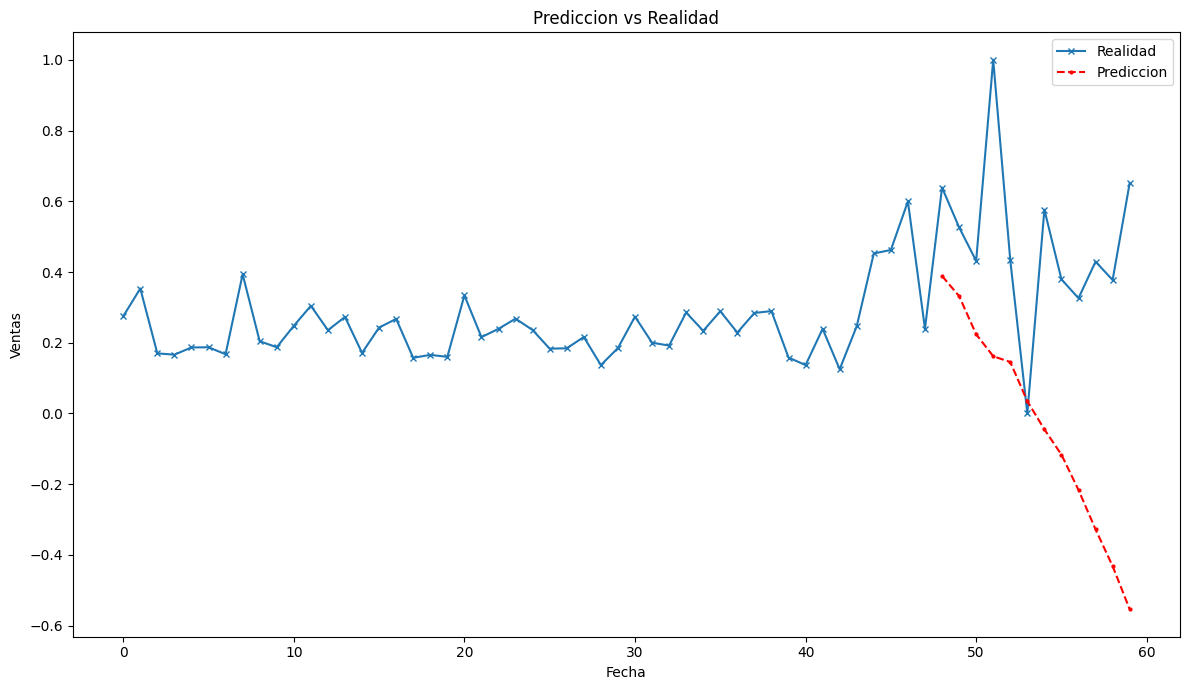

In [23]:
# plot_best_model(df_SQL, predictions_best)
plot_best_model(df_SQL_norm, predictions_best_norm)

In [29]:
results.head(6)

,param,mae,mse,r2,mape
199,"(5, 3, 1)",1.009089e+08,2.215951e+16,-0.088265,0.605697
88,"(2, 2, 4)",1.102714e+08,2.605003e+16,-0.279330,0.613061
150,"(4, 1, 0)",1.097302e+08,2.409436e+16,-0.183286,0.627650
78,"(2, 1, 0)",1.101622e+08,2.483967e+16,-0.219888,0.630619
114,"(3, 1, 0)",1.074192e+08,2.465814e+16,-0.210974,0.637607
124,"(3, 2, 4)",1.283819e+08,3.007263e+16,-0.476882,0.643244


In [28]:
results_norm.head(6)

,param,mae,mse,r2,mape
135,"(3, 4, 3)",0.520267,0.377948,-6.335256,1.303012e+13
134,"(3, 4, 2)",0.502648,0.342959,-5.656178,1.491014e+13
171,"(4, 4, 3)",0.540919,0.404915,-6.858627,1.595904e+13
127,"(3, 3, 1)",0.366672,0.176835,-2.432023,5.520005e+13
120,"(3, 2, 0)",0.340103,0.154276,-1.994194,6.516262e+13
148,"(4, 0, 4)",0.270252,0.112615,-1.185644,6.747262e+13


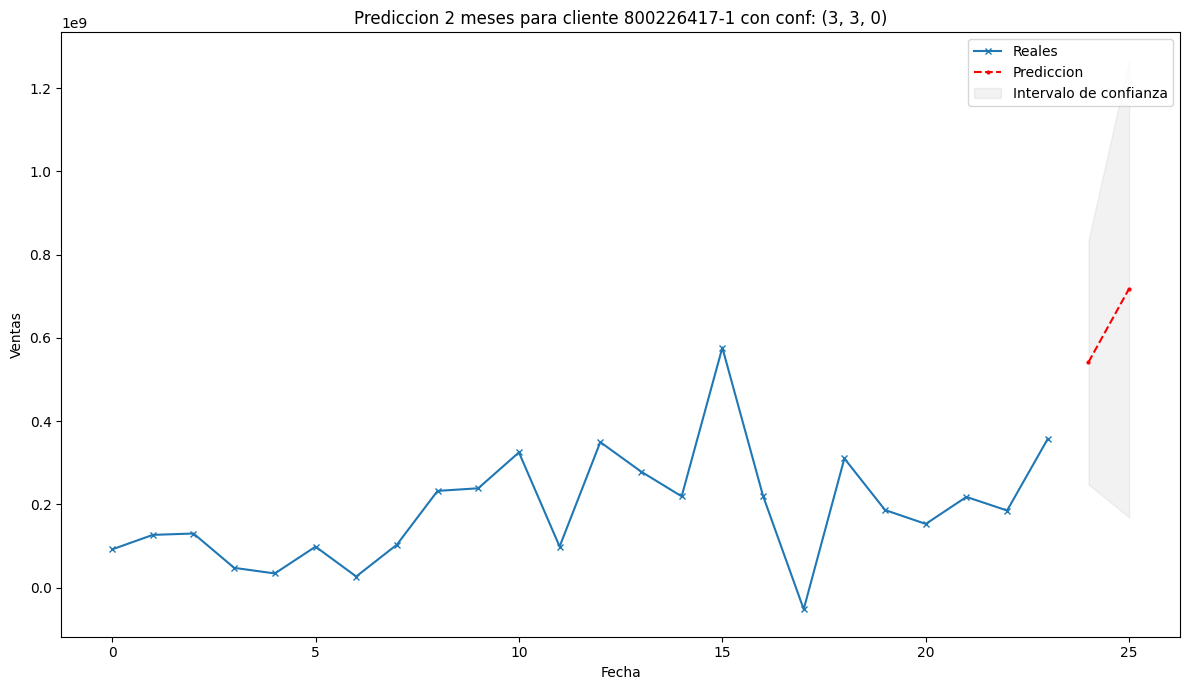

     Prediccion    upper_pred    lower_pred
0  5.416925e+08  8.353065e+08  2.480784e+08
1  7.185623e+08  1.268294e+09  1.688308e+08


In [14]:
predecir_cliente(nit_cliente= "800226417-1", fecha_final= "2022-12-31", n_meses= 2, param= (3,3,0), alpha= 0.01)